# Introduction
This notebook is the fourth in a series of notebooks illustrating how to interface a model to Certifai, run a  scan and perform some simple analyses

## Part 4 - Find Influential Examples to the Fairness Result
In this notebook we'll perform a simple analysis of the counterfactuals to identify the most influential points
behind some of the fairness results

# Locate the reports
Note that the `scan.run` call we made in the previous notebook actually returns a dictionary of the reports, but we can also load reports generally from wherever they have been put, so here we'll just locate and reload them

In [1]:
from certifai.scanner.report_reader import ScanReportReader
import pandas as pd

reader = ScanReportReader("reports")
scans = reader.list_scans('German_credit_use_case')
data=[[s['date'], ', '.join(s['reportTypes']), s['id']] for s in scans]
df = pd.DataFrame(data, columns=['date', 'evals', 'scan id']).sort_values(by=['date'], ascending=False)
latest_scan = df[df['evals'].str.contains('fairness') & df['evals'].str.contains('explanation')].iloc[0]
results = reader.load_scan('German_credit_use_case', latest_scan['scan id'])

In [2]:
from certifai.scanner.explanation_utils import (construct_explanations_dataframe, explanations, 
                                                counterfactual_feature_frequency)

explanation_df = construct_explanations_dataframe(explanations(results))

# Partition by fairness group and favorability
We'll look at the fairness groups defined by the 'status' feature here.  We need to separate the results into sets that represent each fairness class, and also by favorability of the original prediction.  Here we will drill down on the 'logistic' model's influencers.

In [3]:
model = 'logistic'
favorable_outcome = 1
groups = explanation_df['status'].unique()
partitions = {}
for group in groups:
    members = explanation_df[(explanation_df['status']==group) & (explanation_df['model']==model)]
    favorable_rows = members[(members['instance']=='original') & (members['prediction']==favorable_outcome)]['row']
    partitions[group] = {
        'favorable': members[members['row'].isin(favorable_rows)],
        'unfavorable': members[~members['row'].isin(favorable_rows)]
    }

# Calculate burdens for the fairness groups
The next two cells calculate group burdens for the groups defined by the 'status' feature.  This calculation
reproduces those that lie behind the burden charts in the console, and one would not normally need to perform
them explicitly in a notebook, but we do so here to make this notebook self-contained, rather than relying on the console to see certain information

In [4]:
CLIP_TO_MODE_BURDEN_MULTIPLE = 10
MIN_NO_CF_MODE_BURDEN_MULTIPLE = 5

all_dists = []
for group in groups:
    uf = partitions[group]['unfavorable']
    unclipped_unfav = 1./uf[uf['instance']=='counterfactual']['fitness']
    partitions[group]['distances'] = unclipped_unfav
    all_dists += unclipped_unfav.values.tolist()

ss = sorted(all_dists)
p90 = ss[int(len(ss)*.9)]
median = ss[int(len(ss)*.5)]
no_cf_dist = max(min(p90, CLIP_TO_MODE_BURDEN_MULTIPLE*median),
                         MIN_NO_CF_MODE_BURDEN_MULTIPLE*median)

for group in groups:
    p = partitions[group]
    burden = 2*sum(p['distances'].values)/(no_cf_dist*(len(p['favorable'])+len(p['unfavorable'])))
    p['burden'] = burden


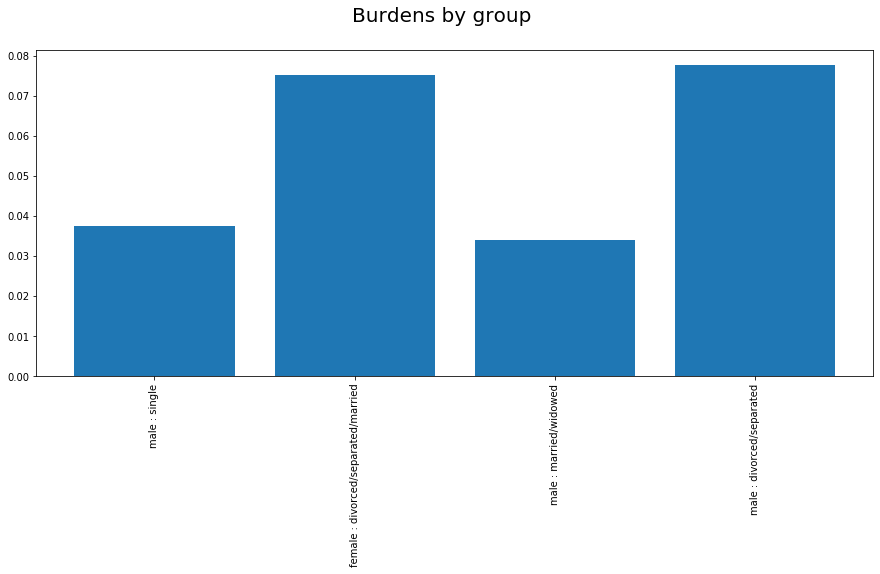

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=[15,6])
fig.suptitle('Burdens by group', fontsize=20)

groups_and_burdens = [(g,p['burden']) for g, p in partitions.items()]

indexes = np.arange(len(groups_and_burdens))
ax.bar(indexes, [gb[1] for gb in groups_and_burdens])
ax.set_xticks(indexes)
ax.set_xticklabels([gb[0] for gb in groups_and_burdens], rotation=90)
    
plt.show()

# Extract influential examples
Because the measure of fairness is disparity in mean burden between groups, the most influential points are those with the highest burden in the higher burden group and the lowest in the lower burden group.  Since the 4 groups here fit nicely into two pairs of high and low burden groups, we'll aggregate them in those pairs for simplicilty of analysis. Note - that all initially favorable examples have 0 burden, so the definition of 'lowest' here is extended slightly to consider the negative burden (i.e. - the margin by which they are favorable)

In [6]:
low_burden_groups = ['male : single', 'male : married/widowed']
low_burden = pd.DataFrame([], columns=explanation_df.columns)
high_burden = pd.DataFrame([], columns=explanation_df.columns)
for group in groups:
    if group in low_burden_groups:
        print(f"Aggregating {group} into low burden")
        low_burden = pd.concat([low_burden, partitions[group]['favorable']])
    else:
        print(f"Aggregating {group} into high burden")
        high_burden = pd.concat([high_burden, partitions[group]['unfavorable']])

low_burden_rows = low_burden.sort_values('fitness', ascending=True)['row'].values
high_burden_rows = high_burden.sort_values('fitness', ascending=True)['row'].values

Aggregating male : single into low burden
Aggregating female : divorced/separated/married into high burden
Aggregating male : married/widowed into low burden
Aggregating male : divorced/separated into high burden


# Display the top points
We show the top 5 contributors to each of the high burden groups and the low burden groups

In [7]:
from certifai.scanner.explanation_utils import counterfactual_changes

pd.set_option('display.max_columns', None)

def display_explanation(df):
    df_original = df[df['instance']=='original']
    display(df_original)
    changes = counterfactual_changes(df)
    display(changes)

def display_top_N(rows, burden_type, n=5):
    print(f"Top {n} points in the {burden_type} burden groups and their corresponding counterfactual changes")
    for idx in range(n):
        row = rows[idx]
        display_explanation(explanation_df[(explanation_df['row']==row) & (explanation_df['model']==model)])
        print()

display_top_N(high_burden_rows, 'high')

Top 5 points in the high burden groups and their corresponding counterfactual changes


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
2048,logistic,25,original,0,original prediction,2,0.00,0 <= ... < 200 DM,60,all credits at this bank paid back duly,purpose - others,14782,100 <= ... < 500 DM,.. >= 7 years,3,female : divorced/separated/married,others - none,4,unknown / no property,> 25 years,bank,for free,2,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,savings,foreign
0,original,0,original prediction,2,0.00,0 <= ... < 200 DM,100 <= ... < 500 DM,foreign - yes
0,counterfactual,1,prediction changed,1,0.33,no checking account,.. >= 1000 DM,foreign - no


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3380,logistic,691,original,0,original prediction,2,0.00,... < 0 DM,36,critical account/ other credits existing (not ...,education,8065,... < 100 DM,1 <= ... < 4 years,3,female : divorced/separated/married,others - none,2,unknown / no property,<= 25 years,none,own,2,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,savings,property
0,original,0,original prediction,2,0.00,... < 100 DM,unknown / no property
0,counterfactual,1,prediction changed,1,0.50,.. >= 1000 DM,"car or other, not in attribute 6"


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3398,logistic,700,original,0,original prediction,2,0.00,... < 0 DM,12,existing credits paid back duly till now,domestic appliances,741,100 <= ... < 500 DM,unemployed,4,female : divorced/separated/married,others - none,3,building society savings agreement/ life insur...,<= 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,foreign
0,original,0,original prediction,2,0.00,foreign - yes
0,counterfactual,1,prediction changed,1,1.00,foreign - no


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3414,logistic,708,original,0,original prediction,2,0.00,... < 0 DM,12,existing credits paid back duly till now,car (new),1228,... < 100 DM,1 <= ... < 4 years,4,female : divorced/separated/married,others - none,2,real estate,<= 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus
0,original,0,original prediction,2,0.00,... < 0 DM
0,counterfactual,1,prediction changed,1,1.00,no checking account


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3430,logistic,716,original,0,original prediction,2,0.00,no checking account,36,existing credits paid back duly till now,furniture/equipment,10974,... < 100 DM,unemployed,4,female : divorced/separated/married,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,2,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,history
0,original,0,original prediction,2,0.00,existing credits paid back duly till now
0,counterfactual,1,prediction changed,1,1.00,critical account/ other credits existing (not ...


In [8]:
display_top_N(low_burden_rows, 'low')

Top 5 points in the low burden groups and their corresponding counterfactual changes


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
2000,logistic,1,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,6,critical account/ other credits existing (not ...,car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


,instance,cf_num,cf_type,prediction,fitness,history,amount,installment,foreign
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,1343,1,foreign - no
0,counterfactual,1,prediction changed,2,0.33,all credits at this bank paid back duly,1373,4,foreign - yes


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3266,logistic,634,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,4,existing credits paid back duly till now,car (new),1494,unknown/ no savings account,... < 1 year,1,male : single,others - none,2,real estate,> 25 years,none,own,1,unskilled - resident,2,phone - none,foreign - no


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,savings,installment,foreign
0,original,0,original prediction,1,0.00,... >= 200 DM / salary assignments for at leas...,unknown/ no savings account,1,foreign - no
0,counterfactual,1,prediction changed,2,0.25,... < 0 DM,... < 100 DM,4,foreign - yes


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3280,logistic,641,original,0,original prediction,1,0.00,no checking account,9,existing credits paid back duly till now,furniture/equipment,1313,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,"car or other, not in attribute 6",<= 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,installment,otherplans
0,original,0,original prediction,1,0.00,no checking account,1,none
0,counterfactual,1,prediction changed,2,0.33,... < 0 DM,4,stores


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3282,logistic,642,original,0,original prediction,1,0.00,no checking account,12,existing credits paid back duly till now,car (new),2859,unknown/ no savings account,unemployed,4,male : single,others - none,4,unknown / no property,> 25 years,none,own,1,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,instance,cf_num,cf_type,prediction,fitness,checkingstatus,savings
0,original,0,original prediction,1,0.00,no checking account,unknown/ no savings account
0,counterfactual,1,prediction changed,2,0.50,... < 0 DM,... < 100 DM


,model,row,instance,cf_num,cf_type,prediction,fitness,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
3288,logistic,645,original,0,original prediction,1,0.00,0 <= ... < 200 DM,9,critical account/ other credits existing (not ...,education,1136,.. >= 1000 DM,.. >= 7 years,4,male : single,others - none,3,unknown / no property,> 25 years,none,for free,2,skilled employee / official,2,phone - none,foreign - yes


,instance,cf_num,cf_type,prediction,fitness,history,savings
0,original,0,original prediction,1,0.00,critical account/ other credits existing (not ...,.. >= 1000 DM
0,counterfactual,1,prediction changed,2,0.50,all credits at this bank paid back duly,... < 100 DM
